# Linear Regression from Scratch vs. scikit-learn

## Project Overview

This notebook demonstrates how to implement multivariate linear regression from scratch and compare its performance with scikit-learn’s `LinearRegression` on a real-world dataset. We use the "Life Expectancy Data.csv" dataset to predict life expectancy based on various features. The notebook includes exploratory data analysis (EDA) and discusses the business value of the project.

## 1. Exploratory Data Analysis (EDA)

Before modeling, i'll explore the dataset to understand its structure, missing values, and relationships between variables. This helps in making informed decisions during preprocessing and feature selection.

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,...,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe,Status_Developed,Status_Developing
0,2015,65.0,263.0,62.0,0.01,71.279624,1154.0,19.1,83.0,6.0,...,False,False,False,False,False,False,False,False,False,True
1,2014,59.9,271.0,64.0,0.01,73.523582,492.0,18.6,86.0,58.0,...,False,False,False,False,False,False,False,False,False,True
2,2013,59.9,268.0,66.0,0.01,73.219243,430.0,18.1,89.0,62.0,...,False,False,False,False,False,False,False,False,False,True
3,2012,59.5,272.0,69.0,0.01,78.184215,2787.0,17.6,93.0,67.0,...,False,False,False,False,False,False,False,False,False,True
4,2011,59.2,275.0,71.0,0.01,7.097109,3013.0,17.2,97.0,68.0,...,False,False,False,False,False,False,False,False,False,True
5,2010,58.8,279.0,74.0,0.01,79.679367,1989.0,16.7,102.0,66.0,...,False,False,False,False,False,False,False,False,False,True
6,2009,58.6,281.0,77.0,0.01,56.762217,2861.0,16.2,106.0,63.0,...,False,False,False,False,False,False,False,False,False,True
7,2008,58.1,287.0,80.0,0.03,25.873925,1599.0,15.7,110.0,64.0,...,False,False,False,False,False,False,False,False,False,True
8,2007,57.5,295.0,82.0,0.02,10.910156,1141.0,15.2,113.0,63.0,...,False,False,False,False,False,False,False,False,False,True
9,2006,57.3,295.0,84.0,0.03,17.171518,1990.0,14.7,116.0,58.0,...,False,False,False,False,False,False,False,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Columns: 213 entries, Year to Status_Developing
dtypes: bool(195), float64(17), int64(1)
memory usage: 972.8 KB


None

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.237066,164.147141,25.329884,4.533468,704.172946,2008.055752,38.345231,35.877672,82.635126,5.903351,82.410143,1.652396,6419.331695,4.775902,4.800953,0.630266,12.030259
std,4.613841,9.434412,121.781876,68.078732,3.887282,1759.271578,7434.980257,19.858584,98.948058,23.309313,2.317144,23.599721,4.423303,12207.455461,4.198046,4.267497,0.204999,3.156940
min,2000.000000,45.600000,4.370000,0.000000,0.010000,0.000000,0.000000,2.300000,0.000000,6.000000,1.257400,6.000000,0.100000,24.455693,0.200000,0.100000,0.000000,2.900000
25%,2004.000000,63.200000,74.000000,0.000000,1.092500,4.685343,0.000000,19.400000,0.000000,78.000000,4.370000,78.000000,0.100000,580.486996,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.600000,227.000000,22.000000,7.390000,441.534144,360.250000,56.100000,28.000000,97.000000,7.330000,97.000000,0.800000,4779.405190,7.100000,7.200000,0.772000,14.100000
max,2015.000000,86.630000,583.040000,495.040000,13.450000,10199.412527,54163.360000,72.063000,767.820000,99.000000,12.707100,99.000000,29.278000,62233.867014,19.500000,19.900000,0.923000,19.000000


Missing values per column:
 Year                 0
Life expectancy      0
Adult Mortality      0
infant deaths        0
Alcohol              0
                    ..
Country_Yemen        0
Country_Zambia       0
Country_Zimbabwe     0
Status_Developed     0
Status_Developing    0
Length: 213, dtype: int64


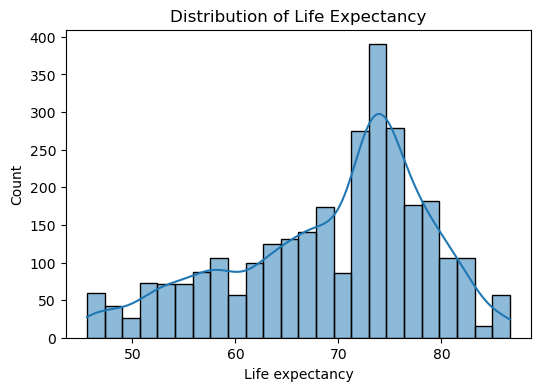

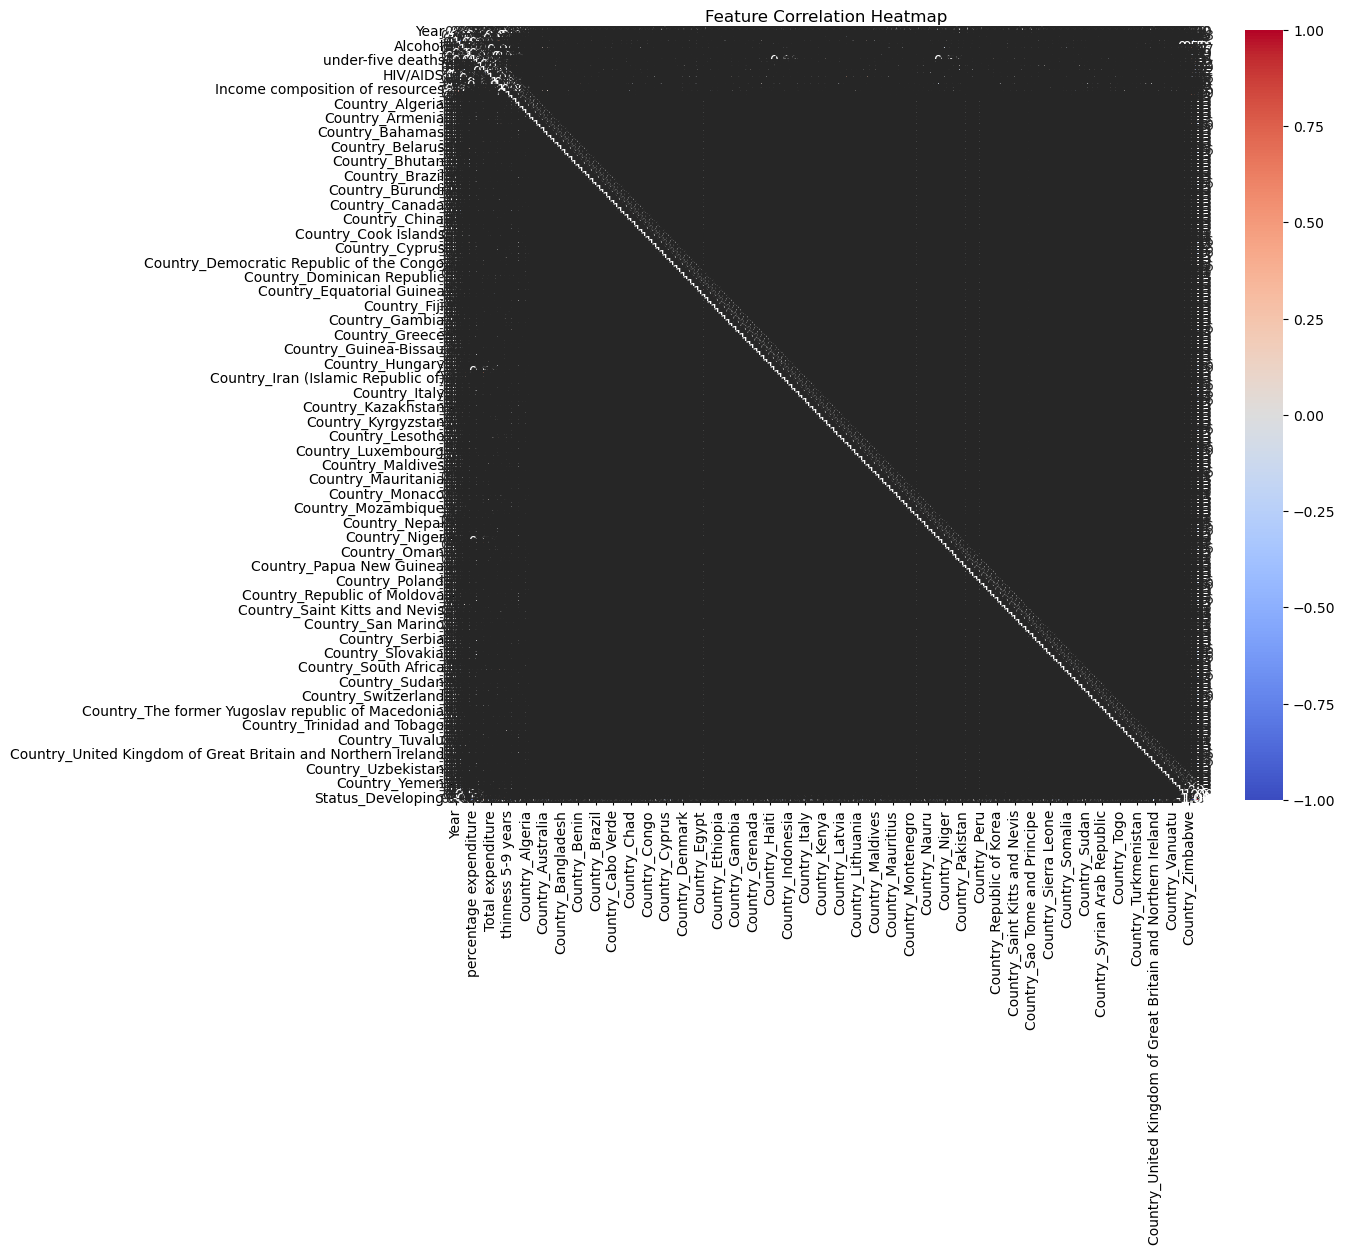

In [4]:
# Load the dataset for EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the path and target column
data_path =  'life_expectancy_cleaned.csv' #'Life Expectancy Data.csv'
target_col = 'Life expectancy'  # Note the space at the end

try:
    data = pd.read_csv(data_path)
except FileNotFoundError:
    raise FileNotFoundError(f"File '{data_path}' not found. Please ensure the dataset is in the working directory.")

# Display basic info
display(data.head(10))
display(data.info())
display(data.describe())

# Check for missing values
missing = data.isnull().sum()
print("Missing values per column:\n", missing)

# Visualize the distribution of the target variable
plt.figure(figsize=(6,4))
sns.histplot(data[target_col], kde=True)
plt.title('Distribution of Life Expectancy')
plt.show()

# Correlation heatmap (only for numeric columns)
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Value of the Project

Accurate life expectancy prediction is valuable for public health officials, policymakers, and researchers. It helps in:
- Identifying key health and socio-economic drivers of life expectancy
- Guiding resource allocation and policy interventions
- Monitoring and improving population health outcomes

By comparing a custom implementation with a standard library, we also gain deeper insight into the mechanics of linear regression and model evaluation.

## 2. Import Required Libraries

We import all necessary libraries for data manipulation, visualization, model building, and evaluation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time 
%matplotlib inline

## 3. Data Loading and Preprocessing

We drop categorical columns, fill missing values with the mean, and split the data for training and testing.

In [41]:
# Identify categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Drop categorical columns from the dataset
X = data.drop(columns=[target_col])
X_nocat = X.drop(columns=categorical_cols)

# Handle missing values (simple imputation: fill with mean)
X_nocat = X_nocat.fillna(X_nocat.mean())
y = data[target_col].values
y = np.where(np.isnan(y), np.nanmean(y), y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_nocat.values, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Linear Regression Implementation

We implement linear regression from scratch using gradient descent and track the training loss.

In [42]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def _initialize_parameters(self, n_features):
        """Initialize weights and bias."""
        self.weights = np.random.randn(n_features, 1) * 0.01
        self.bias = 0
    
    def fit(self, X, y):
        """Train the model using gradient descent."""
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        for _ in range(self.n_iter):
            # Predictions
            y_pred = np.dot(X, self.weights) + self.bias
            
            # Gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y.reshape(-1, 1)))
            db = (1 / n_samples) * np.sum(y_pred - y.reshape(-1, 1))
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute and store loss
            loss = np.mean((y_pred - y.reshape(-1, 1)) ** 2)
            self.loss_history.append(loss)
    
    def predict(self, X):
        """Make predictions."""
        return np.dot(X, self.weights) + self.bias
    
    def evaluate(self, X_test, y_test):
        """Compute MSE and R²."""
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

### Train and Evaluate Custom Linear Regression Model

In [43]:
custom_model = LinearRegression(learning_rate=0.01, n_iter=1000)
custom_model.fit(X_train, y_train)
custom_mse, custom_r2 = custom_model.evaluate(X_test, y_test)
print(f"Custom Model - MSE: {custom_mse:.4f}, R²: {custom_r2:.4f}")

Custom Model - MSE: 16.3601, R²: 0.8112


### Train and Evaluate scikit-learn Linear Regression Model

In [44]:
# Train scikit-learn model
sk_model = SkLinearRegression()
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_mse = mean_squared_error(y_test, sk_pred)
sk_r2 = r2_score(y_test, sk_pred)
print(f"scikit-learn - MSE: {sk_mse:.4f}, R²: {sk_r2:.4f}")

scikit-learn - MSE: 15.3609, R²: 0.8227


### Compare Model Coefficients

We compare the learned coefficients from both models to see if they are similar.

In [45]:
# Use X_nocat.columns as the feature names, since that's what was used for training
feature_names = list(X_nocat.columns) + ["Intercept"]
custom_coefs = np.vstack([custom_model.weights, custom_model.bias]).flatten()
sk_coefs = np.append(sk_model.coef_.flatten(), sk_model.intercept_)

coefficients = pd.DataFrame({
    "Feature": feature_names,
    "Custom Model": custom_coefs,
    "scikit-learn": sk_coefs
})
print(coefficients)

                            Feature  Custom Model  scikit-learn
0                              Year     -0.049177     -0.028457
1                   Adult Mortality     -2.691564     -2.649419
2                     infant deaths      0.283202     10.817481
3                           Alcohol      0.332728      0.457691
4            percentage expenditure      0.264246      0.224618
5                       Hepatitis B     -0.424827     -0.380865
6                          Measles      -0.411301     -0.279055
7                              BMI       0.812025      0.786777
8                under-five deaths      -0.451236    -10.981840
9                             Polio      0.728933      0.650194
10                Total expenditure      0.165895      0.147295
11                      Diphtheria       1.077664      0.957360
12                         HIV/AIDS     -2.482518     -2.433248
13                              GDP      0.404155      0.491650
14                       Population     

### Visualize Training Loss Curve

Plotting the loss curve helps us understand the convergence of the custom model.

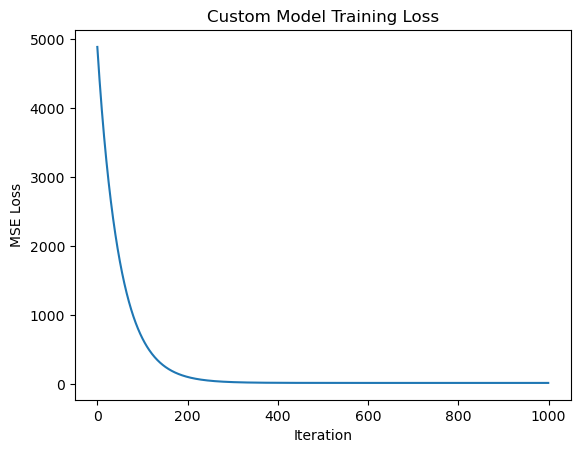

In [46]:
plt.plot(range(len(custom_model.loss_history)), custom_model.loss_history)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Custom Model Training Loss")
plt.show()

### Prediction Comparison

We compare the predictions of both models against the true values.

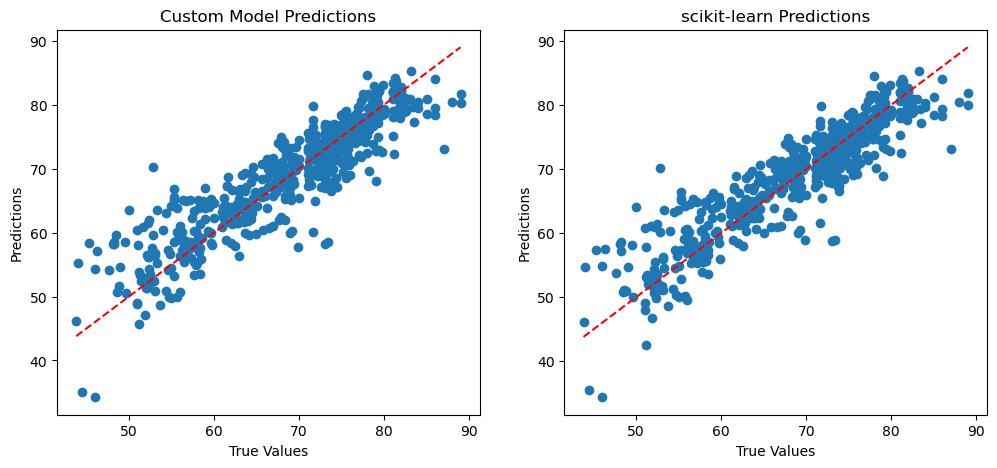

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, custom_model.predict(X_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Custom Model Predictions")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.subplot(1, 2, 2)
plt.scatter(y_test, sk_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("scikit-learn Predictions")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

### Check Working Directory

This helps ensure the notebook is running in the expected directory for file loading.

In [ ]:
import os
print(os.getcwd())

## Suggestions for Improvement

Here are some ways to further improve this notebook:

1. **Feature Engineering**
   - Explore feature selection or dimensionality reduction (e.g., PCA) to see if model performance improves.
   - Consider creating interaction terms or polynomial features if non-linear relationships are suspected.

2. **Missing Data Handling**
   - Try more advanced imputation methods (e.g., KNN imputer, regression imputation) instead of mean imputation.
   - Analyze the impact of missing data on model performance.

3. **Model Evaluation**
   - Add cross-validation to assess model stability.
   - Report additional metrics (e.g., MAE, RMSE) for a more comprehensive evaluation.
   - Include residual analysis plots to check for model assumptions (e.g., homoscedasticity, normality).

4. **Hyperparameter Tuning**
   - Experiment with different learning rates and iteration counts for the custom model, possibly using a grid search or Optuna.

5. **Visualization**
   - Add more EDA visualizations (e.g., pairplots, boxplots for outliers, target vs. top features).
   - Visualize feature importances or coefficients more clearly (e.g., bar plots).

6. **Reproducibility & Documentation**
   - Set random seeds for reproducibility.
   - Add more comments and markdown explanations, especially for custom code.
   - Summarize findings and next steps at the end of the notebook.

7. **Business/Application Context**
   - Discuss potential real-world applications and limitations of the model.
   - Suggest how stakeholders could use the predictions.

If you would like to implement any of these improvements, let me know which area you'd like to focus on!